In [54]:
from collections import deque
import seaborn as sns
import numpy as np

### Definição das estruturas de dados

In [100]:
class PriorityQueue:
    
    def __init__(self, chave=lambda x: x): # Parametrizado com a função usada para comparação. Assim, a classe é mais versátil.
        self.heap = []
        self.chave = chave

    def menor(self):
        if len(self.heap) == 0:
            raise RuntimeError("Tentando ver o menor valor da fila de prioridade vazia")
            
        return self.heap[0]
    def vazia(self):
        if len(self.heap) == 0:
            return True
        else:
            return False
        
    def pop(self):
        if len(self.heap) == 0:
            raise RuntimeError("Tentando extrair valor da fila de prioridade vazia")
            
        menor = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.desce(0)

        # print("heap: ", self.heap) # debug

        return menor

    def add(self, valor):
        self.heap.append(valor)
        self.sobe(len(self.heap) - 1)
        
        # print("Heap:", self.heap) # debug
    
    def sobe(self, indice):
        if indice == 0: # Já está "no topo"
            return

        pai = (indice - 1) // 2
        if self.chave(self.heap[indice]) < self.chave(self.heap[pai]): # Se o novo elemento for maior que o pai
            tmp = self.heap[pai]
            self.heap[pai] = self.heap[indice]
            self.heap[indice] = tmp
            self.sobe(pai)

    def desce(self, indice):
        idx_filho_esq, idx_filho_dir = indice * 2 + 1, indice * 2 + 2

        if len(self.heap) <= idx_filho_esq:
            return
        if len(self.heap) == idx_filho_dir:
            filho_esq = self.heap[idx_filho_esq]
            filho_dir = None
        else:
            filho_esq, filho_dir = self.heap[idx_filho_esq], self.heap[idx_filho_dir]

        if filho_dir is None or self.chave(filho_esq) < self.chave(filho_dir):
            menor_filho = filho_esq
            idx_menor_filho = idx_filho_esq
        else:
            menor_filho = filho_dir
            idx_menor_filho = idx_filho_dir
        
        if self.chave(self.heap[indice]) > self.chave(menor_filho):    
            tmp = self.heap[idx_menor_filho]
            self.heap[idx_menor_filho] = self.heap[indice]
            self.heap[indice] = tmp
            self.desce(idx_menor_filho)
            

### Amostragens das VAs necessárias

#### Exponencial
Para amostrar essa VA, vamos utilizar o método da inversa da CDF. Dado que a pdf de $X \sim Exp(\lambda)$ é dada por
$$f(x) = \lambda e^{-\lambda x}$$

Podemos calcular a cdf $F(x)$ por:
$$F(x) = \int_{-\infty}^x \lambda e^{-\lambda t} dt = \int_0^x \lambda e^{-\lambda t} dt = $$
$$\left. -e^{-\lambda t} \right\rvert^x_0 = -e^{-\lambda x} - (- e^0) = $$
$$1 - e^{-\lambda x}$$

E para calcular $F^{-1}(x)$,
$$y = 1 - e^{-\lambda x}$$

Queremos encontrar $x$ em função de $y$,
$$y - 1 = -e^{-\lambda x}$$
$$1 - y = e^{-\lambda x}$$
$$ln(1 - y) = -\lambda x$$
$$-\frac{ln(1 - y)}{\lambda} = x$$
$$F^{-1}(x) = -\frac{ln(1 - x)}{\lambda}$$

#### Uniforme
Para essa VA $X \sim Unif(a, b)$, a pdf é dada por
$$f(x) = \frac{1}{b - a}$$

Calculando a cdf,
$$F(x) = \int_{-\infty}^x = \int_a^t \frac{1}{b - a} dt = $$
$$\left. \frac{t}{b - a}\right\rvert^x_a = \frac{x}{b - a} - \frac{a}{b - a} = \frac{x - a}{b - a}$$
$$F(x) = \frac{x - a}{b - a}$$

Calculando a inversa:
$$y = \frac{x - a}{b - a}$$
$$y(b - a) = x - a$$
$$x = y(b - a) + a$$
$$F^{-1}(x) = x(b - a) + a$$

In [52]:
class VAExponencial: # Para modelar o "Inter-Arrival Time" e os tamanhos dos jobs no terceiro cenário
    def __init__(self, Lambda):
        self.Lambda = Lambda

    def inversa_cdf(self, x):
        return -(np.log(1 - x)/self.Lambda)
    
    def amostrar(self):
        return self.inversa_cdf(np.random.rand())
        
class VAConstante: # Distribuição dos tamanhos dos jobs no primeiro cenário
    def __init__(self, c):
        self.param = c
    
    def amostrar(self):
        return self.param

class VAUniforme: # Distribuição dos tamanhos dos jobs no segundo cenário
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def inversa_cdf(self, x):
        return x * (self.b - self.a) + self.a
    
    def amostrar(self):
        return self.inversa_cdf(np.random.rand())

(0.0, 4.0)

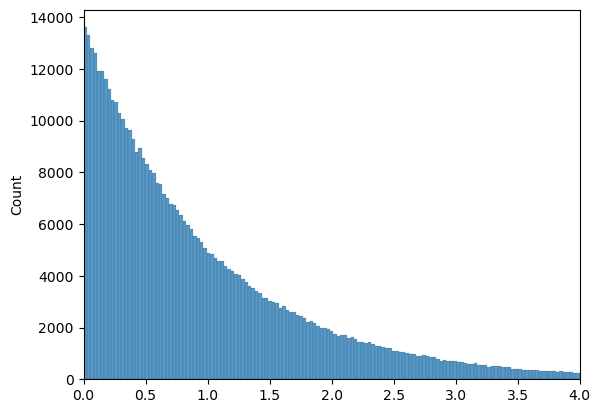

In [47]:
num_amostras = 500000
exp = VAExponencial(1)
lista = [exp.amostrar() for _ in range(num_amostras)]

histograma = sns.histplot(lista)
histograma.set_xlim(0, 4)

<Axes: ylabel='Count'>

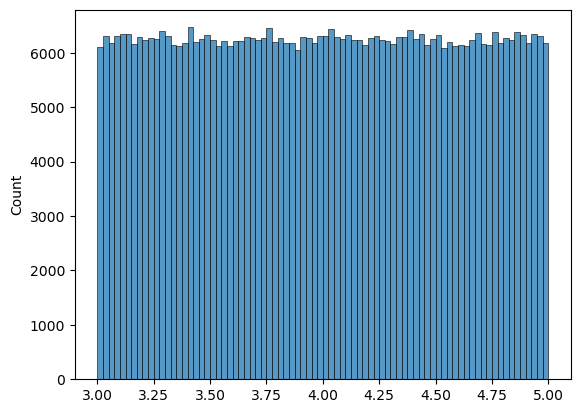

In [51]:
unif = VAUniforme(3, 5)
lista = [unif.amostrar() for i in range(num_amostras)]

histograma = sns.histplot(lista)
histograma

### Setup da Simulação

In [105]:
CHEGADA = 0
SAIDA_S1 = 1
SAIDA_S2 = 2
SAIDA_S3 = 3

fila_de_eventos = PriorityQueue(chave=lambda x: x[1])

inter_arrival_time = 2 # Processo de Poisson
exp = VAExponencial(inter_arrival_time)

fila_s1 = deque()
fila_s2 = deque()
fila_s3 = deque()

params_constante = [0.4, 0.6, 0.95]
params_uniforme = [(0.1, 0.7), (0.1, 1.1), (0.1, 1.8)]
params_exponencial = [0.4, 0.6, 0.95]

# "warmup"
ultima_chegada = 0
for _ in range(10000):
    ultima_chegada += exp.amostrar()
    fila_de_eventos.add((CHEGADA, ultima_chegada))

### TODO
- Implementar amostragens de VAs
- Implementar filas de jobs
- Pensar em uma estrutura de dados para eventos
- Pensar na estrutura de dados para as métricas de cada job (ID para colher as métricas)